### GMMs of line-emission

In [1]:
import os
import numpy as np
import fitsio
from astropy.table import Table

In [63]:
from fastspecfit.io import FLUXNORM
from fastspecfit.util import TabulatedDESI
cosmo = TabulatedDESI()

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Choose the lines of interest

Limit ourselves to the "major" emission lines.

In [2]:
from importlib import resources
emlinesfile = resources.files('fastspecfit').joinpath('data/emlines.ecsv')
emlines = Table.read(emlinesfile)
emlines = emlines[emlines['amp'] > 0.1]
I = np.logical_or.reduce((emlines['name'] == 'lyalpha', emlines['name'] == 'mgii_2796', 
                          emlines['name'] == 'mgii_2803', emlines['isbroad'] == False))
emlines = emlines[I]
print(len(emlines))
emlines

13


name,restwave,amp,isbalmer,ishelium,isbroad,nicename,plotgroup
str15,float64,float32,bool,bool,bool,str60,str32
lyalpha,1215.67,1.0,False,False,True,Ly$\alpha$,lya
mgii_2796,2796.3511,1.0,False,False,True,"MgII-$\lambda\lambda$2796,2803",mgii_2796_2803
mgii_2803,2803.5324,1.0,False,False,True,"MgII-$\lambda\lambda$2796,2803",mgii_2796_2803
oii_3726,3727.0919,1.0,False,False,False,"[OII]-$\lambda\lambda$3726,29",oii_3726_29
oii_3729,3729.875,1.0,False,False,False,"[OII]-$\lambda\lambda$3726,29",oii_3726_29
neiii_3869,3869.8611,1.0,False,False,False,[NeIII]-$\lambda$3869+H6,neiii_3869_h6
hgamma,4341.684,1.0,True,False,False,H$\gamma$-$\lambda$4340+[OIII]-$\lambda$4363,hgamma_oiii_4363
hbeta,4862.683,1.0,True,False,False,H$\beta$-$\lambda$4861,hbeta
oiii_4959,4960.2937,1.0,False,False,False,"[OIII]-$\lambda\lambda$4959,5007",oiii_doublet


In [3]:
from fastspecfit.io import cache_templates, get_templates_filename
templatefile = get_templates_filename()
templatecache = cache_templates(read_linefluxes=True)
templatecache.keys()
#F = fitsio.FITS(templatefile)
#F

dict_keys(['imf', 'vdisp_nominal', 'templateinfo', 'templatewave', 'templateflux', 'templateflux_nomvdisp', 'templateflux_nolines', 'templateflux_nolines_nomvdisp', 'vdispflux', 'vdispwave', 'vdisp', 'vdisp_nominal_indx', 'linefluxes', 'linewaves'])

In [46]:
def get_template_lineindex():
    I = []
    for emline in emlines:
        if emline['name'] == 'nev_3346':
            # [NeV] 3346 is not in the FSPS templates; they have [NeIII] 3343, which we do not; so skip it
            continue
        ii = np.argmin(np.abs(emline['restwave'] - templatecache['linewaves']))
        I.append(ii)
        print(f'{emline["name"]:10s} {emline["restwave"]:.2f} {templatecache["linewaves"][ii]:.2f}')
    I = np.array(I)
    return I

template_lineindex = get_template_lineindex()

lyalpha    1215.67 1215.67
mgii_2796  2796.35 2796.40
mgii_2803  2803.53 2803.58
oii_3726   3727.09 3727.12
oii_3729   3729.88 3730.12
neiii_3869 3869.86 3869.92
hgamma     4341.68 4341.75
hbeta      4862.68 4862.76
oiii_4959  4960.29 4960.37
oiii_5007  5008.24 5008.31
halpha     6564.61 6564.72
sii_6716   6718.29 6718.40
sii_6731   6732.67 6732.78


In [13]:
LINEFLUXCOLS = [f'{emline.upper()}_FLUX' for emline in emlines['name']]

### Read the data

Read the parent sample used for template-building, pull out the columns of the lines we care about (and some additional columns), and zero out lines which are not detected above a minimum signal-to-noise ratio.

In [8]:
ff = '/global/cfs/cdirs/desicollab/users/ioannis/fastspecfit/redrock-templates/stacks/parent-BGS.fits'
tt = Table(fitsio.read(ff, 'FASTSPEC'))
mm = Table(fitsio.read(ff, 'METADATA'))

In [12]:
#tt['FLUX']

In [40]:
def read_data():
    ff = '/global/cfs/cdirs/desicollab/users/ioannis/fastspecfit/redrock-templates/stacks/parent-BGS.fits'
    tt = Table(fitsio.read(ff, 'FASTSPEC'))
    #mm = Table(fitsio.read(ff, 'METADATA'))
    
    morecols = ['SURVEY', 'PROGRAM', 'HEALPIX', 'TARGETID', 'Z', 'LOGMSTAR', 'FLUX_SYNTH_PHOTMODEL_R', 'COEFF']
    
    lineivarcols = [f'{emline.upper()}_FLUX_IVAR' for emline in emlines['name']]
    allcols = morecols + LINEFLUXCOLS
    
    jj = tt[allcols]
    for fluxcol, ivarcol in zip(LINEFLUXCOLS, lineivarcols):
        L = tt[fluxcol] * np.sqrt(tt[ivarcol]) < 5.
        if np.any(L):
            jj[fluxcol][L] = 0.
            
    jj['DLUM'] = cosmo.luminosity_distance(jj['Z'])
            
    return jj    

In [41]:
data = read_data()
data

SURVEY,PROGRAM,HEALPIX,TARGETID,Z,LOGMSTAR,FLUX_SYNTH_PHOTMODEL_R,COEFF,LYALPHA_FLUX,MGII_2796_FLUX,MGII_2803_FLUX,OII_3726_FLUX,OII_3729_FLUX,NEIII_3869_FLUX,HGAMMA_FLUX,HBETA_FLUX,OIII_4959_FLUX,OIII_5007_FLUX,HALPHA_FLUX,SII_6716_FLUX,SII_6731_FLUX,DLUM
str3,str6,int32,int64,float64,float32,float32,float32[40],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64
sv3,bright,25915,39627733927462296,0.21160522322111827,9.713437,15.35273,0.0 .. 0.0,0.0,0.0,0.0,27.292267,34.614563,0.0,0.0,25.903568,0.0,19.48399,74.561516,17.749792,11.968279,729.0171449989449
sv3,bright,25914,39627733927462346,0.20831648335368,10.107794,17.623062,0.00037025404 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.83935,9.967945,0.0,716.3537875485354
sv3,bright,25915,39627733927463205,0.2731793132075421,10.084076,8.856319,0.0015024577 .. 0.0,0.0,0.0,0.0,23.896305,30.457218,0.0,0.0,24.036009,0.0,18.146423,92.442085,19.757685,13.472651,973.0445379983363
sv3,bright,25915,39627733927463584,0.18493751813414697,10.438245,47.154266,6.494362e-05 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,627.4557562989022
sv3,bright,25915,39627733927463809,0.18570904385178735,10.920659,63.91824,0.0012703007 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.641716,0.0,0.0,630.3577046450698
sv3,bright,25915,39627733927464298,0.3122080927766551,10.363598,12.468832,0.00032861988 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.87249,0.0,0.0,1134.24851716162
sv3,bright,25915,39627733927464616,0.05429547129868816,10.647275,250.29799,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.120384,15.267055,10.992665,169.38671998440387
sv3,bright,25915,39627733927464793,0.2662350306119081,10.747855,20.83333,0.00041530235 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.8804157147033
sv3,bright,25915,39627733927464814,0.5381649004009763,11.071679,15.406128,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.981492,0.0,0.0,0.0,0.0,0.0,2154.371145166594


In [65]:
I = np.where((data['OIII_5007_FLUX'] > 0) * (data['HBETA_FLUX'] > 0) * (data['HALPHA_FLUX'] == 0))[0][0]
data[I][LINEFLUXCOLS]

LYALPHA_FLUX,MGII_2796_FLUX,MGII_2803_FLUX,OII_3726_FLUX,OII_3729_FLUX,NEIII_3869_FLUX,HGAMMA_FLUX,HBETA_FLUX,OIII_4959_FLUX,OIII_5007_FLUX,HALPHA_FLUX,SII_6716_FLUX,SII_6731_FLUX
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0.0,0.0,0.0,17.351469,22.676262,0.0,11.105587,23.897589,0.0,11.7165985,0.0,0.0,0.0


In [74]:
def get_template_linefluxes(data, MASSNORM=1e10):
    redshift = data['Z']
    dlum = data['DLUM']

    T = FLUXNORM * MASSNORM * (10. / (1e6 * dlum))**2 / (1. + redshift)
    linefluxes = data['COEFF'].dot(templatecache['linefluxes'][template_lineindex, :].T) * T
    
    return linefluxes
    
linefluxes = data[LINEFLUXCOLS][I]
template_linefluxes = get_template_linefluxes(data[I])
    
for emline, lineflux, template_lineflux in zip(emlines, linefluxes, template_linefluxes):
    print(f'{emline["name"]:10s}  {lineflux:.4f}   {template_lineflux:.4f}')

lyalpha     0.0000   100.9566
mgii_2796   0.0000   1.5991
mgii_2803   0.0000   0.8335
oii_3726    17.3515   23.1176
oii_3729    22.6763   31.2448
neiii_3869  0.0000   10.9369
hgamma      11.1056   29.4757
hbeta       23.8976   71.9178
oiii_4959   0.0000   54.4178
oiii_5007   11.7166   165.4571
halpha      0.0000   288.1390
sii_6716    0.0000   15.3918
sii_6731    0.0000   11.9354


In [ ]:
stop

In [30]:
LINEFLUXCOLS[7]

'HBETA_FLUX'

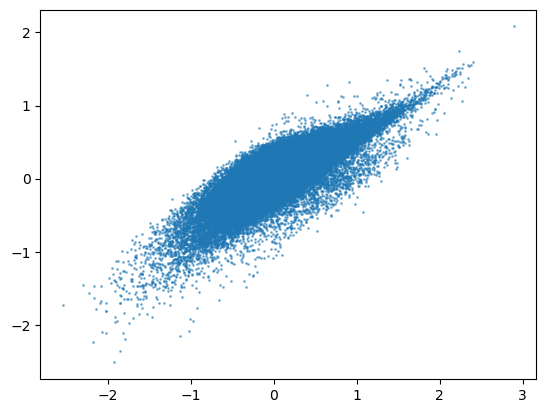

In [33]:
I = (data[LINEFLUXCOLS[9]] > 0) * (data[LINEFLUXCOLS[7]] > 0)
plt.scatter(np.log10(data[LINEFLUXCOLS[9]][I] / data['FLUX_SYNTH_PHOTMODEL_R'][I]), 
            np.log10(data[LINEFLUXCOLS[7]][I] / data['FLUX_SYNTH_PHOTMODEL_R'][I]), s=1, alpha=0.5)

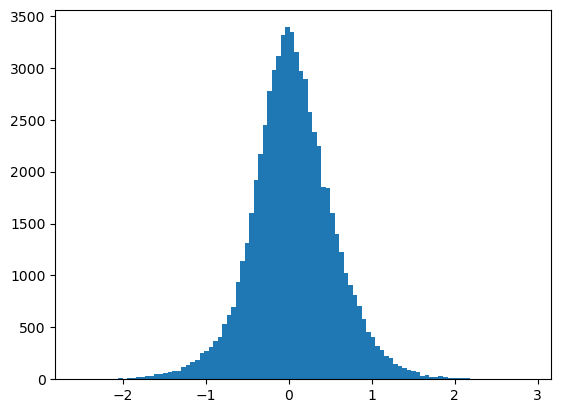

In [24]:
I = (data[LINEFLUXCOLS[9]] > 0)
_ = plt.hist(np.log10(data[LINEFLUXCOLS[9]][I] / data['FLUX_SYNTH_PHOTMODEL_R'][I]), bins=100)